In [1]:
import os
import sys
import time
import random
import warnings
import collections
from dateutil.relativedelta import relativedelta
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.experimental import enable_hist_gradient_boosting, enable_halving_search_cv  
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, HalvingRandomSearchCV 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, StackingRegressor, HistGradientBoostingRegressor 

# from sklearn.linear_model import Ridge, Lasso, BayesianRidge, ElasticNet
from sklearn.preprocessing import OneHotEncoder

sys.path.append('../../src')
import cb_utils
import cb_model_utils

sns.set(style="darkgrid")
pd.options.display.max_columns = 500

%load_ext autoreload
%autoreload 2

/Users/bp/miniforge3/envs/data-analytics/lib/python3.10/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


### Load raw data

In [2]:
query = f"select * from junk.ml_training_samples_20250210;"
df = cb_utils.sql_query_to_df(query, use_cache=True, source='msh_analytics')

Pulling query from db


In [3]:
df.head()

,payer_id,period_number,member_id,pre_elg_days,age_ft,is_male_ft,is_female_ft,ip_tc_pre_pmpm_ft,ed_tc_pre_pmpm_ft,snf_tc_pre_pmpm_ft,icf_tc_pre_pmpm_ft,hh_tc_pre_pmpm_ft,out_tc_pre_pmpm_ft,pro_tc_pre_pmpm_ft,hcbs_tc_pre_pmpm_ft,sphs_tc_pre_pmpm_ft,amb_tc_pre_pmpm_ft,dme_tc_pre_pmpm_ft,hosp_tc_pre_pmpm_ft,dialysis_ddos_pre_pmpm_ft,pulmonar_ddos_pre_pmpm_ft,copd_ddos_pre_pmpm_ft,chf_ddos_pre_pmpm_ft,heart_ddos_pre_pmpm_ft,cancer_ddos_pre_pmpm_ft,ckd_ddos_pre_pmpm_ft,esrd_ddos_pre_pmpm_ft,hyperlipid_ddos_pre_pmpm_ft,diab_ddos_pre_pmpm_ft,alzh_ddos_pre_pmpm_ft,dementia_ddos_pre_pmpm_ft,neurocognitive_ddos_pre_pmpm_ft,stroke_ddos_pre_pmpm_ft,hypertension_ddos_pre_pmpm_ft,fall_ddos_pre_pmpm_ft,transplant_ddos_pre_pmpm_ft,liver_ddos_pre_pmpm_ft,hippfract_ddos_pre_pmpm_ft,depression_ddos_pre_pmpm_ft,psychosis_ddos_pre_pmpm_ft,drug_ddos_pre_pmpm_ft,alcohol_ddos_pre_pmpm_ft,paralysis_ddos_pre_pmpm_ft,hemophilia_ddos_pre_pmpm_ft,pressure_ulcer_ddos_pre_pmpm_ft,tbi_ddos_pre_pmpm_ft,obese_ddos_pre_pmpm_ft,post_elig_days,tc_tg,tc_pmpm_tg
0,81,19,20362,181,68.0,1,0,0.00,0.0,0.0,0.0,0.00,6.30,119.95,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.17,0.00,0.0,0.0,0.0,0.00,0.17,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,365,676.96,5.56
1,81,19,20363,181,90.0,0,1,2530.75,0.0,3756.4,0.0,387.25,0.00,434.10,0.0,0.0,100.83,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.5,0.0,0.0,0.83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,365,27889.78,229.23
2,81,19,20368,181,76.0,0,1,0.00,0.0,0.0,0.0,1240.69,0.00,69.43,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.17,0.17,0.17,0.17,0.0,0.0,0.0,0.00,0.17,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,365,13185.44,108.37
3,81,19,20371,181,73.0,1,0,0.00,0.0,0.0,0.0,0.00,1.21,123.45,0.0,0.0,0.00,7.05,0.0,0.0,0.0,0.0,0.33,1.49,0.0,0.00,0.00,0.99,0.00,0.0,0.0,0.0,0.17,0.33,0.0,0.0,0.0,0.00,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,365,31207.91,256.50
4,81,19,20374,181,71.0,1,0,0.00,0.0,0.0,0.0,583.64,0.00,46.70,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.17,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,365,4454.73,36.61


In [4]:
df.shape

(1765592, 50)

In [5]:
df.member_id.nunique()

146076

### Train test split

In [25]:
train_pct = 0.8
# Get unique member IDs and randomly split them
all_members = df.member_id.unique()
np.random.seed(42)
train_members = np.random.choice(all_members, size=int(len(all_members) * train_pct), replace=False)
test_members = np.setdiff1d(all_members, train_members)

# Split dataframes based on member lists
train_df = df[df.member_id.isin(train_members)].copy()
test_df = df[df.member_id.isin(test_members)].copy()

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"\nUnique members in train: {train_df.member_id.nunique()}")
print(f"Unique members in test: {test_df.member_id.nunique()}")



Train shape: (1411865, 50)
Test shape: (353727, 50)

Unique members in train: 116860
Unique members in test: 29216


In [26]:
# Get feature columns ending in _ft
feature_cols = [col for col in train_df.columns if col.endswith('_ft')]
target_col = 'tc_pmpm_tg'

# Create feature matrix X and target vector y
X_train = train_df[feature_cols]
y_train = train_df[target_col]
X_test = test_df[feature_cols]
y_test = test_df[target_col]

# Import required modules
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

# Initialize scaler and model
scaler = StandardScaler()
model = LinearRegression()

# Setup k-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

# Perform cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    # Split data
    X_fold_train = X_train.iloc[train_idx]
    y_fold_train = y_train.iloc[train_idx]
    X_fold_val = X_train.iloc[val_idx]
    y_fold_val = y_train.iloc[val_idx]
    
    # Scale features
    X_fold_train_scaled = scaler.fit_transform(X_fold_train)
    X_fold_val_scaled = scaler.transform(X_fold_val)
    
    # Train model
    model.fit(X_fold_train_scaled, y_fold_train)
    
    # Make predictions
    y_pred = model.predict(X_fold_val_scaled)
    
    # Calculate R2 score
    r2 = r2_score(y_fold_val, y_pred)
    cv_scores.append(r2)
    
    print(f"Fold {fold + 1} R² Score: {r2:.4f}")

print(f"\nMean CV R² Score: {np.mean(cv_scores):.4f}")
print(f"Std CV R² Score: {np.std(cv_scores):.4f}")

# Train final model on full training set
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model.fit(X_train_scaled, y_train)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': model.coef_
})
feature_importance['abs_coefficient'] = abs(feature_importance['coefficient'])
feature_importance = feature_importance.sort_values('abs_coefficient', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# # Evaluate on test set
# y_pred_test = model.predict(X_test_scaled)
# test_r2 = r2_score(y_test, y_pred_test)
# test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

# print(f"\nTest Set R² Score: {test_r2:.4f}")
# print(f"Test Set RMSE: {test_rmse:.4f}")


Fold 1 R² Score: 0.1867
Fold 2 R² Score: 0.1990
Fold 3 R² Score: 0.2046
Fold 4 R² Score: 0.1788
Fold 5 R² Score: 0.2042

Mean CV R² Score: 0.1946
Std CV R² Score: 0.0102

Top 10 Most Important Features:
                feature   coefficient  abs_coefficient
1            is_male_ft  4.439177e+11     4.439177e+11
2          is_female_ft  4.439177e+11     4.439177e+11
10  hcbs_tc_pre_pmpm_ft -2.854876e+08     2.854876e+08
6    icf_tc_pre_pmpm_ft -1.729264e+08     1.729264e+08
11  sphs_tc_pre_pmpm_ft  1.307570e+08     1.307570e+08
8    out_tc_pre_pmpm_ft  5.008530e+01     5.008530e+01
9    pro_tc_pre_pmpm_ft  2.495750e+01     2.495750e+01
7     hh_tc_pre_pmpm_ft  1.974131e+01     1.974131e+01
13   dme_tc_pre_pmpm_ft  1.693095e+01     1.693095e+01
0                age_ft  1.395207e+01     1.395207e+01


In [8]:
# Initialize HistGradientBoostingRegressor
model = HistGradientBoostingRegressor(random_state=42)

# Initialize cross-validation scores list
cv_scores = []

# Perform k-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    # Split data
    X_fold_train = X_train.iloc[train_idx]
    X_fold_val = X_train.iloc[val_idx]
    y_fold_train = y_train.iloc[train_idx]
    y_fold_val = y_train.iloc[val_idx]
    
    # Scale features
    X_fold_train_scaled = scaler.fit_transform(X_fold_train)
    X_fold_val_scaled = scaler.transform(X_fold_val)
    
    # Train model
    model.fit(X_fold_train_scaled, y_fold_train)
    
    # Make predictions
    y_pred = model.predict(X_fold_val_scaled)
    
    # Calculate R2 score
    r2 = r2_score(y_fold_val, y_pred)
    cv_scores.append(r2)
    
    print(f"Fold {fold + 1} R² Score: {r2:.4f}")

print(f"\nMean CV R² Score: {np.mean(cv_scores):.4f}")
print(f"Std CV R² Score: {np.std(cv_scores):.4f}")

Fold 1 R² Score: 0.2502
Fold 2 R² Score: 0.2657
Fold 3 R² Score: 0.2636
Fold 4 R² Score: 0.2613
Fold 5 R² Score: 0.2678

Mean CV R² Score: 0.2617
Std CV R² Score: 0.0062


In [9]:
# Calculate permutation feature importance
from sklearn.inspection import permutation_importance
# Split training data into train and validation sets
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, 
    test_size=0.2,
    random_state=42
)

# Scale the features
X_train_final_scaled = scaler.fit_transform(X_train_final)
X_val_scaled = scaler.transform(X_val)

# Train model on final training set
model.fit(X_train_final_scaled, y_train_final)

# Evaluate on validation set
y_val_pred = model.predict(X_val_scaled)
val_r2 = r2_score(y_val, y_val_pred)
print(f"\nValidation Set R² Score: {val_r2:.4f}")

# Calculate permutation importance on validation set
result = permutation_importance(
    model, X_fold_val_scaled, y_fold_val,
    n_repeats=10,
    random_state=42
)

# Create DataFrame of feature importances
importances = pd.DataFrame(
    {'feature': X_train.columns,
     'importance': result.importances_mean,
     'std': result.importances_std}
)
importances = importances.sort_values('importance', ascending=False)




Validation Set R² Score: 0.2593


In [16]:

# %% cell 12 code

# Display top 20 most important features
print("Top 20 Most Important Features:")
print(importances.head(20))

# %% cell 13 code


Top 20 Most Important Features:
                            feature  importance       std
8                out_tc_pre_pmpm_ft    0.139547  0.001211
9                pro_tc_pre_pmpm_ft    0.053384  0.000470
0                            age_ft    0.026600  0.000929
20          cancer_ddos_pre_pmpm_ft    0.023065  0.000418
13               dme_tc_pre_pmpm_ft    0.022814  0.000721
7                 hh_tc_pre_pmpm_ft    0.018346  0.000265
24            diab_ddos_pre_pmpm_ft    0.011343  0.000711
5                snf_tc_pre_pmpm_ft    0.011018  0.000279
17            copd_ddos_pre_pmpm_ft    0.010277  0.000341
23      hyperlipid_ddos_pre_pmpm_ft    0.010079  0.000412
31      transplant_ddos_pre_pmpm_ft    0.008899  0.000336
40  pressure_ulcer_ddos_pre_pmpm_ft    0.008385  0.000139
29    hypertension_ddos_pre_pmpm_ft    0.008153  0.000677
19           heart_ddos_pre_pmpm_ft    0.007293  0.000415
32           liver_ddos_pre_pmpm_ft    0.007076  0.000385
14              hosp_tc_pre_pmpm_ft    0

In [13]:
importances.head(55)


,feature,importance,std
8,out_tc_pre_pmpm_ft,0.139547,0.001211
9,pro_tc_pre_pmpm_ft,0.053384,0.000470
0,age_ft,0.026600,0.000929
20,cancer_ddos_pre_pmpm_ft,0.023065,0.000418
13,dme_tc_pre_pmpm_ft,0.022814,0.000721
7,hh_tc_pre_pmpm_ft,0.018346,0.000265
24,diab_ddos_pre_pmpm_ft,0.011343,0.000711
5,snf_tc_pre_pmpm_ft,0.011018,0.000279
17,copd_ddos_pre_pmpm_ft,0.010277,0.000341
23,hyperlipid_ddos_pre_pmpm_ft,0.010079,0.000412


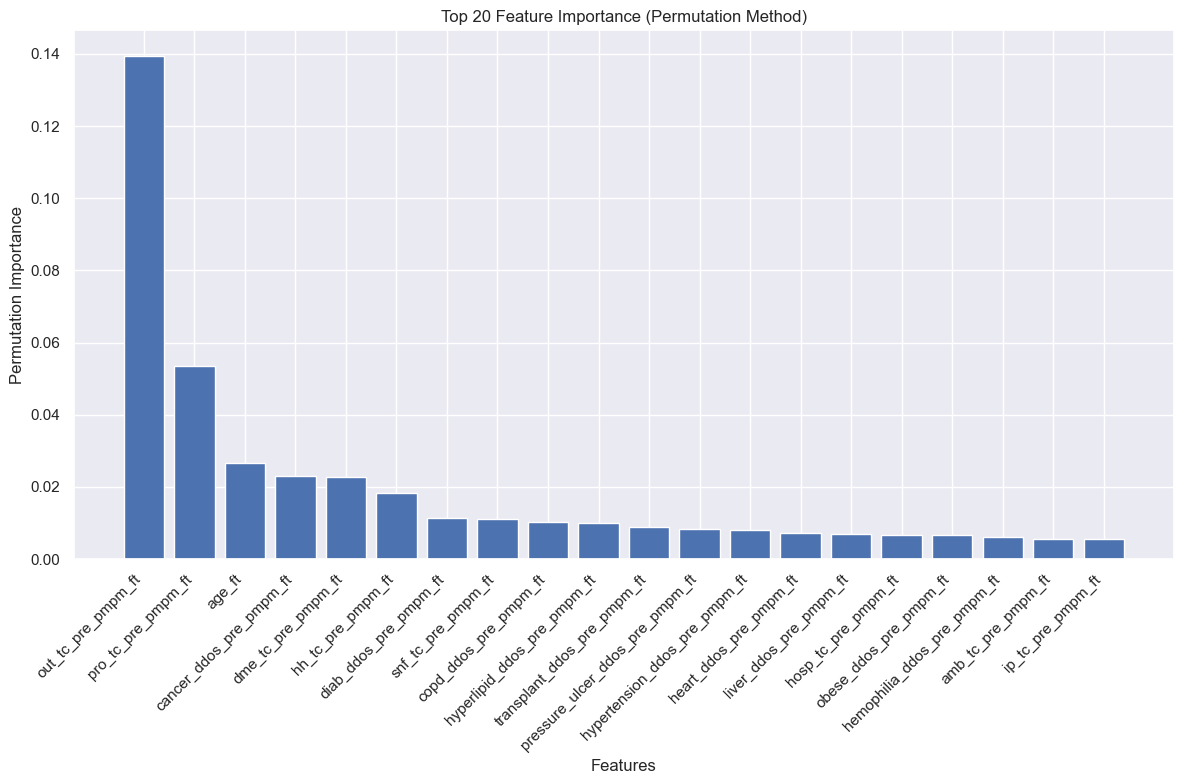

In [17]:

# Create bar plot of feature importance
plt.figure(figsize=(12, 8))
plt.bar(range(20), importances['importance'][:20])
plt.xticks(range(20), importances['feature'][:20], rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Permutation Importance')
plt.title('Top 20 Feature Importance (Permutation Method)')
plt.tight_layout()
plt.show()


In [10]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_iter': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [20, 50, 100]
}
grid_search = GridSearchCV(HistGradientBoostingRegressor(random_state=42),
                          param_grid,
                          cv=5,
                          scoring='r2')
grid_search.fit(X_train_scaled, y_train)
print(grid_search.best_params_)

{'learning_rate': 0.1, 'max_depth': 7, 'max_iter': 300, 'min_samples_leaf': 20}


In [11]:
# try model with best params
# Initialize HistGradientBoostingRegressor
model = HistGradientBoostingRegressor(random_state=42, **grid_search.best_params_)

# Initialize cross-validation scores list
cv_scores = []

# Perform k-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    # Split data
    X_fold_train = X_train.iloc[train_idx]
    X_fold_val = X_train.iloc[val_idx]
    y_fold_train = y_train.iloc[train_idx]
    y_fold_val = y_train.iloc[val_idx]
    
    # Scale features
    X_fold_train_scaled = scaler.fit_transform(X_fold_train)
    X_fold_val_scaled = scaler.transform(X_fold_val)
    
    # Train model
    model.fit(X_fold_train_scaled, y_fold_train)
    
    # Make predictions
    y_pred = model.predict(X_fold_val_scaled)
    
    # Calculate R2 score
    r2 = r2_score(y_fold_val, y_pred)
    cv_scores.append(r2)
    
    print(f"Fold {fold + 1} R² Score: {r2:.4f}")

print(f"\nMean CV R² Score: {np.mean(cv_scores):.4f}")
print(f"Std CV R² Score: {np.std(cv_scores):.4f}")



Fold 1 R² Score: 0.2753
Fold 2 R² Score: 0.2949
Fold 3 R² Score: 0.2854
Fold 4 R² Score: 0.2797
Fold 5 R² Score: 0.2878

Mean CV R² Score: 0.2846
Std CV R² Score: 0.0067


In [32]:
# try model with the best params and clip the target to 0
# Initialize HistGradientBoostingRegressor
model = HistGradientBoostingRegressor(random_state=42, **grid_search.best_params_)

# Initialize cross-validation scores list
cv_scores = []

# Perform k-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    # Split data
    X_fold_train = X_train.iloc[train_idx]
    X_fold_val = X_train.iloc[val_idx]
    y_fold_train = y_train.iloc[train_idx].clip(lower=0)
    y_fold_val = y_train.iloc[val_idx].clip(lower=0)
    
    # Scale features
    X_fold_train_scaled = scaler.fit_transform(X_fold_train)
    X_fold_val_scaled = scaler.transform(X_fold_val)
    
    # Train model
    model.fit(X_fold_train_scaled, y_fold_train)
    
    # Make predictions
    y_pred = model.predict(X_fold_val_scaled)
    
    # Calculate R2 score
    r2 = r2_score(y_fold_val, y_pred)
    cv_scores.append(r2)
    
    print(f"Fold {fold + 1} R² Score: {r2:.4f}")

print(f"\nMean CV R² Score: {np.mean(cv_scores):.4f}")
print(f"Std CV R² Score: {np.std(cv_scores):.4f}")



Fold 1 R² Score: 0.2793
Fold 2 R² Score: 0.2933
Fold 3 R² Score: 0.2854
Fold 4 R² Score: 0.2783
Fold 5 R² Score: 0.2891

Mean CV R² Score: 0.2851
Std CV R² Score: 0.0057


In [17]:
train_df.tc_pmpm_tg.value_counts()


0.00       60699
3.10         340
6.34         338
4.61         333
3.80         328
           ...  
905.60         1
563.19         1
2922.59        1
1519.56        1
1253.94        1
Name: tc_pmpm_tg, Length: 92234, dtype: int64

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# For each fold or on your test set
y_pred = model.predict(X_test_scaled)

# Calculate various metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"RMSE: ${rmse:.2f}")
print(f"MAE: ${mae:.2f}")
print(f"MAPE: {mape:.2%}")

RMSE: $319.48
MAE: $96.25
MAPE: 777172748660710400.00%


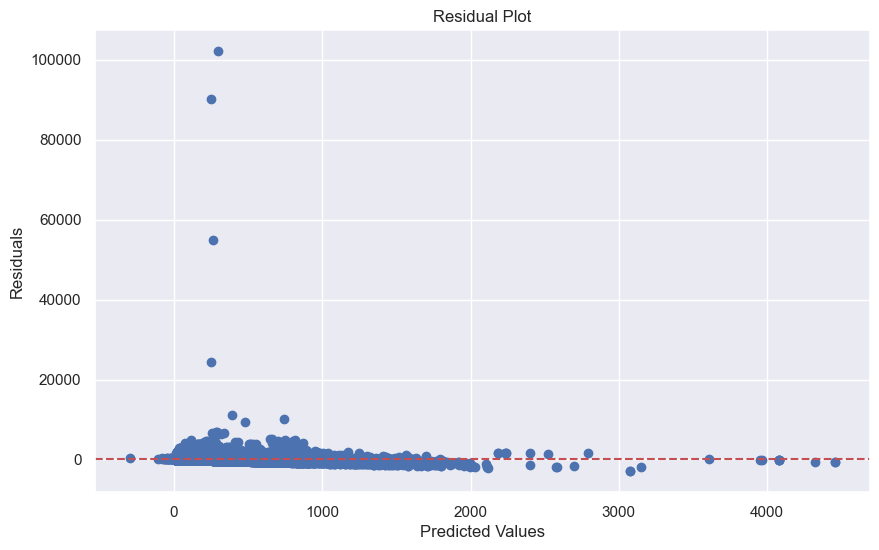

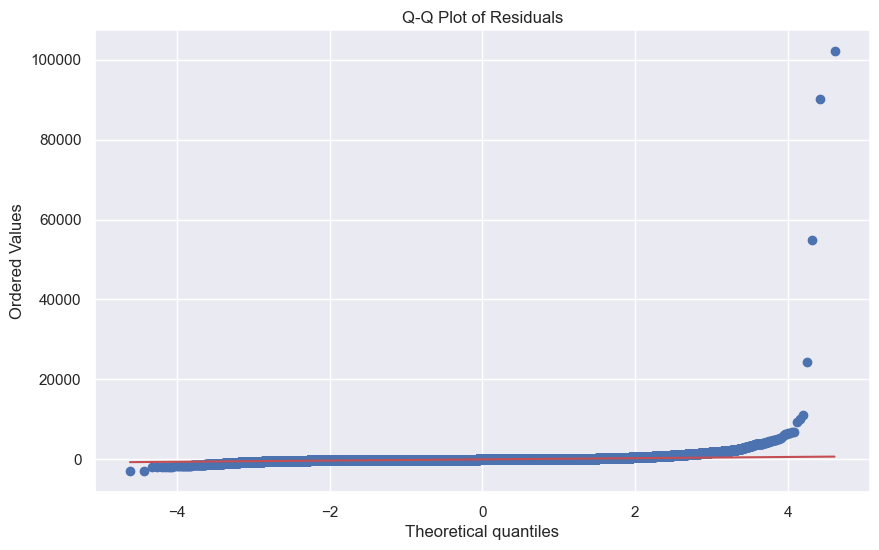

In [21]:
# Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Q-Q plot for normality check
from scipy import stats
fig, ax = plt.subplots(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=ax)
plt.title("Q-Q Plot of Residuals")
plt.show()

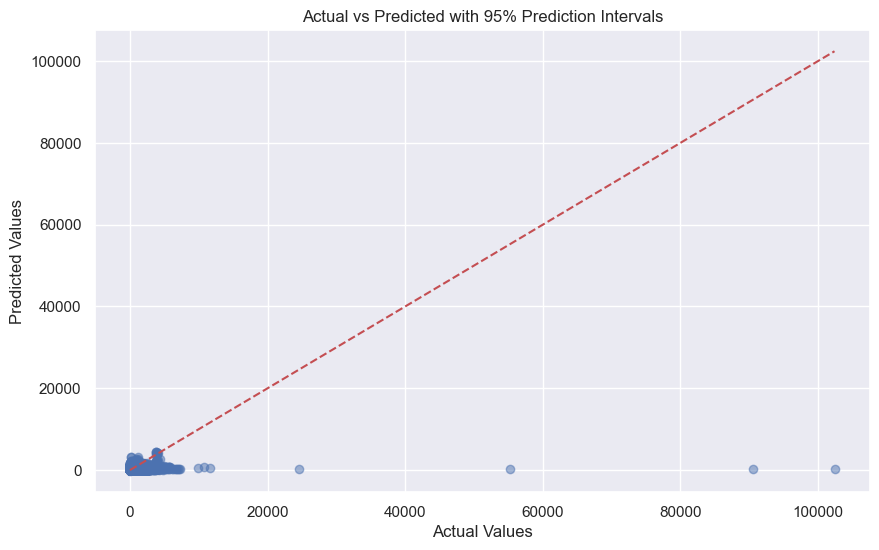

In [22]:
# Using bootstrapping to estimate prediction intervals
predictions = []
n_iterations = 100

for i in range(n_iterations):
    # Sample with replacement
    indices = np.random.randint(0, len(X_train), len(X_train))
    sample_X = X_train_scaled[indices]
    sample_y = y_train.iloc[indices]
    
    # Fit model and predict
    model.fit(sample_X, sample_y)
    predictions.append(model.predict(X_test_scaled))

# Calculate prediction intervals
predictions = np.array(predictions)
lower = np.percentile(predictions, 2.5, axis=0)
upper = np.percentile(predictions, 97.5, axis=0)

# Plot actual vs predicted with intervals
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted with 95% Prediction Intervals')
plt.show()

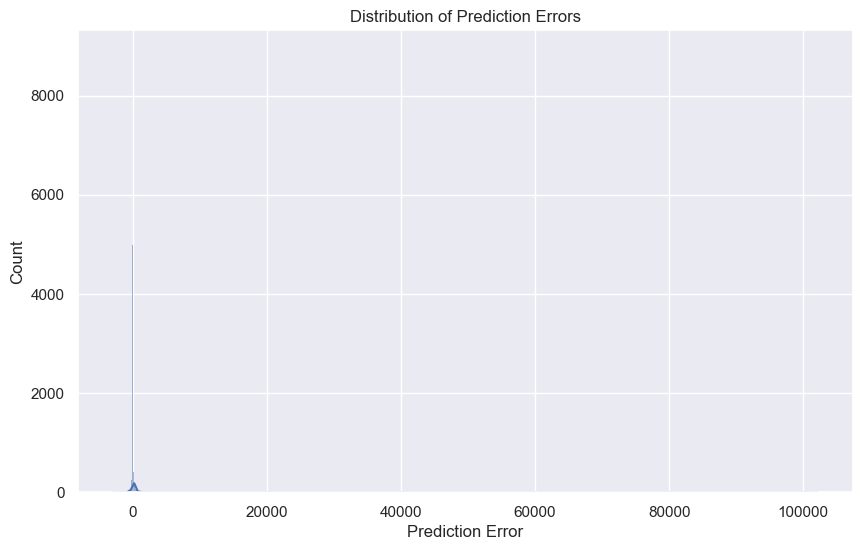


Error Statistics:
Mean Error                                           -0.898152
Median Error                                        -31.311746
Std Error                                           319.476338
95% Error Interval    [-208.02840837084165, 475.1415624514893]
dtype: object


In [23]:
# Visualize error distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.show()

# Calculate error statistics
error_stats = pd.Series({
    'Mean Error': residuals.mean(),
    'Median Error': np.median(residuals),
    'Std Error': residuals.std(),
    '95% Error Interval': np.percentile(residuals, [2.5, 97.5])
})
print("\nError Statistics:")
print(error_stats)